<a href="https://colab.research.google.com/github/tundeakins/PLD-TESS/blob/master/fast_gp_breakout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U lightkurve exoplanet pymc3 corner

     |████████████████████████████████| 1.2MB 2.8MB/s 
     |████████████████████████████████| 1.7MB 18.2MB/s 
     |████████████████████████████████| 1.9MB 26.6MB/s 
     |████████████████████████████████| 256kB 42.6MB/s 
     |████████████████████████████████| 6.5MB 39.3MB/s 
     |████████████████████████████████| 25.9MB 1.3MB/s 
     |████████████████████████████████| 1.5MB 44.0MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 4.3MB 45.4MB/s 
     |████████████████████████████████| 296kB 51.0MB/s 
     |████████████████████████████████| 2.6MB 44.0MB/s 
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.5.2 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
import lightkurve as lk

In [ ]:
lcfs = lk.search_lightcurvefile("TIC 10863087")
lcfs

#,observation,target_name,productFilename,distance
0,TESS Sector 3,10863087,tess2018263035959-s0003-0000000010863087-0123-s_lc.fits,0.0


In [ ]:
lc = lcfs[0].download().PDCSAP_FLUX.normalize().remove_nans().remove_outliers()

In [ ]:
%matplotlib inline

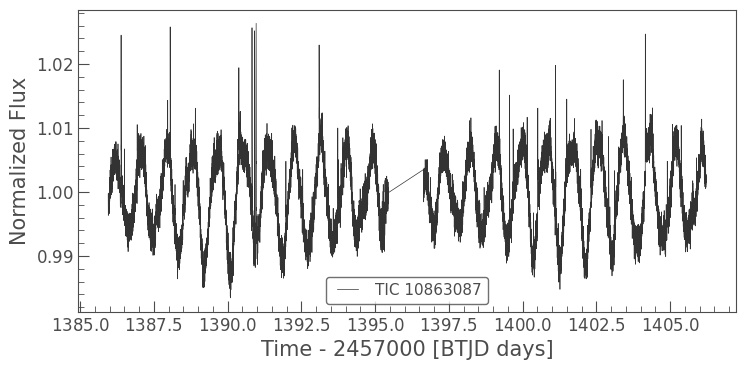

In [ ]:
lc.plot();

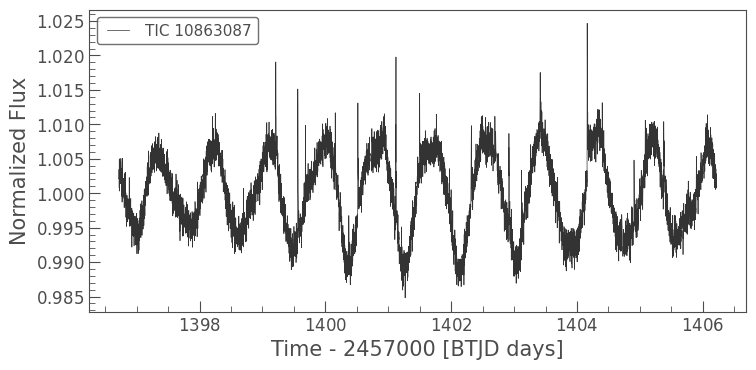

In [ ]:
lc = lc[len(lc) // 2 :]
lc.plot()

In [ ]:
_, mask = lc.flatten().remove_outliers(sigma=3.0, return_mask=True)

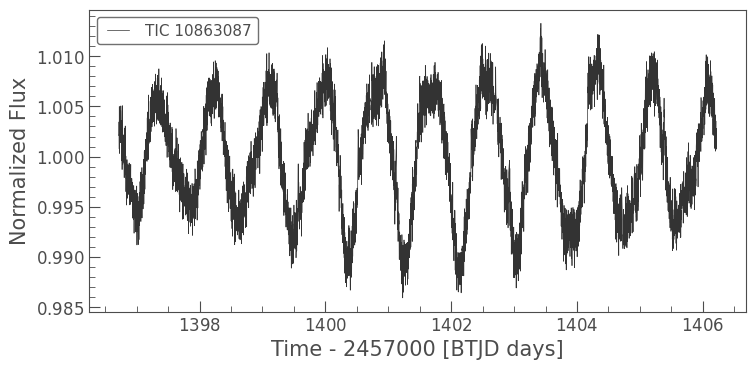

In [ ]:
lc[~mask].plot()

In [ ]:
import numpy as np

x = np.ascontiguousarray(lc.time[~mask], dtype=np.float64)
y = np.ascontiguousarray(1e3 * (lc.flux[~mask] - 1), dtype=np.float64)
yerr = np.ascontiguousarray(1e3 * lc.flux_err[~mask], dtype=np.float64)

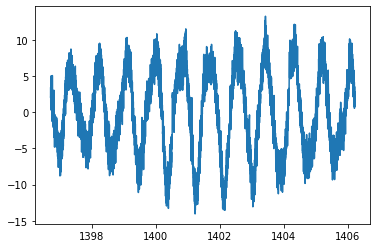

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x, y);

In [ ]:
import exoplanet as xo

In [ ]:
acf = xo.estimators.autocorr_estimator(x, y, yerr)

In [ ]:
acf

{'autocorr': (array([0.00000000e+00, 6.94442644e-04, 1.38888529e-03, ...,
         9.50275314e+00, 9.50344758e+00, 9.50414203e+00]),
  array([9.74431811e-01, 9.73557862e-01, 9.71936602e-01, ...,
         3.97054217e-05, 3.61683763e-05, 3.43427468e-05])),
 'peaks': [{'period': 0.8756921741969563, 'period_uncert': nan}]}

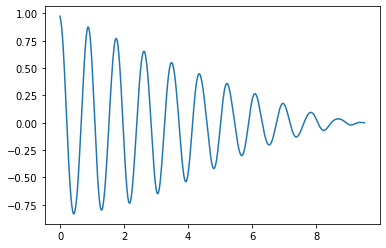

In [ ]:
plt.plot(*acf["autocorr"]);

In [ ]:
import pymc3 as pm

with pm.Model() as model:

    mean_flux = pm.Normal("mean_flux", mu=0.0, sigma=10.0)
    sigma = pm.HalfNormal("sigma", sigma=np.mean(yerr))

    amp = pm.Lognormal("amp", mu=np.log(np.var(y)), sigma=10.0)
    period = pm.Lognormal("period", mu=np.log(acf["peaks"][0]["period"]), sigma=10.0)
    Q0 = pm.Lognormal("Q0", mu=0.0, sigma=10.0)
    deltaQ = pm.Lognormal("deltaQ", mu=0.0, sigma=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1)

    kernel = xo.gp.terms.RotationTerm(amp=amp, period=period, Q0=Q0, deltaQ=deltaQ, mix=mix)
    gp = xo.gp.GP(kernel, x, diag=yerr ** 2 + sigma ** 2, mean=mean_flux)

    gp.marginal("obs", observed=y)

    print(model.check_test_point())

mean_flux            -3.22
sigma_log__          -0.77
amp_log__            -3.22
period_log__         -3.22
Q0_log__             -3.22
deltaQ_log__         -3.22
mix_interval__       -1.39
obs              -12159.08
Name: Log-probability of test_point, dtype: float64


In [ ]:
with model:

    soln = xo.optimize(vars=[mean_flux, sigma])
    soln = xo.optimize(soln)

optimizing logp for variables: [sigma, mean_flux]


message: Optimization terminated successfully.
logp: -12177.34276545519 -> -11888.692881209136


optimizing logp for variables: [mix, deltaQ, Q0, period, amp, sigma, mean_flux]


message: Desired error not necessarily achieved due to precision loss.
logp: -11888.692881209136 -> -11811.600251955842


In [ ]:
with model:

    pred = xo.eval_in_model(gp.predict(), soln)

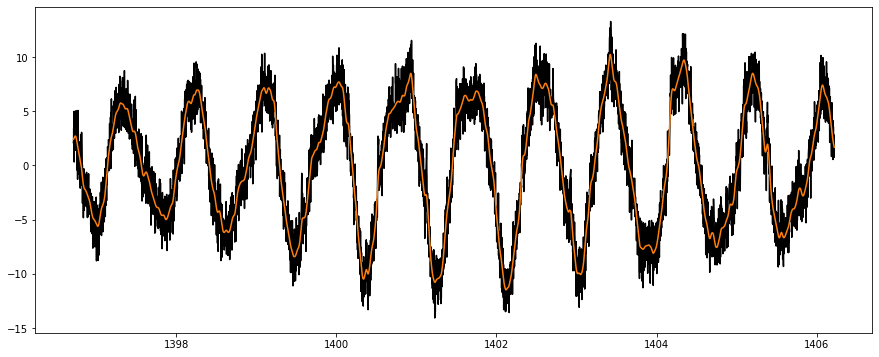

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(x, y, "k")
plt.plot(x, pred, "C1")

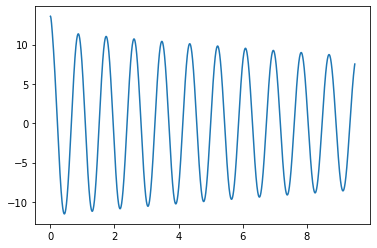

In [ ]:
with model:

    plt.plot(acf["autocorr"][0], xo.eval_in_model(kernel.value(acf["autocorr"][0]), soln))

In [ ]:
with model:

    trace = pm.sample(step=xo.get_dense_nuts_step(target_accept=0.9))

Sequential sampling (2 chains in 1 job)
NUTS: [mix, deltaQ, Q0, period, amp, sigma, mean_flux]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 285 seconds.


In [ ]:
with model:
    summary = pm.summary(trace)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_flux,-0.041,0.376,-0.746,0.659,0.009,0.009,1664.0,820.0,1676.0,1347.0,1.0
sigma,0.088,0.062,0.000,0.199,0.002,0.001,1439.0,1439.0,1083.0,708.0,1.0
amp,31.791,14.993,13.635,58.818,0.473,0.336,1005.0,998.0,1512.0,1055.0,1.0
period,0.808,0.030,0.751,0.863,0.001,0.001,1671.0,1648.0,1733.0,1186.0,1.0
Q0,0.005,0.002,0.002,0.008,0.000,0.000,1571.0,1404.0,1705.0,1313.0,1.0
deltaQ,5.755,3.434,1.807,11.605,0.113,0.083,927.0,867.0,1270.0,967.0,1.0
mix,0.013,0.005,0.004,0.022,0.000,0.000,1632.0,1632.0,1515.0,1083.0,1.0


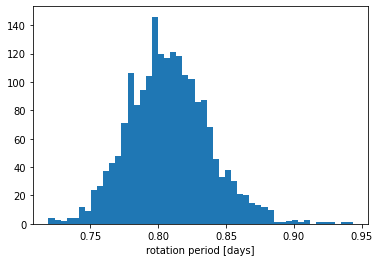

In [ ]:
plt.hist(trace["period"], 50)
plt.xlabel("rotation period [days]");

In [ ]:
np.mean(trace["period"]), np.std(trace["period"])

(0.8079963101682963, 0.030031866176096548)

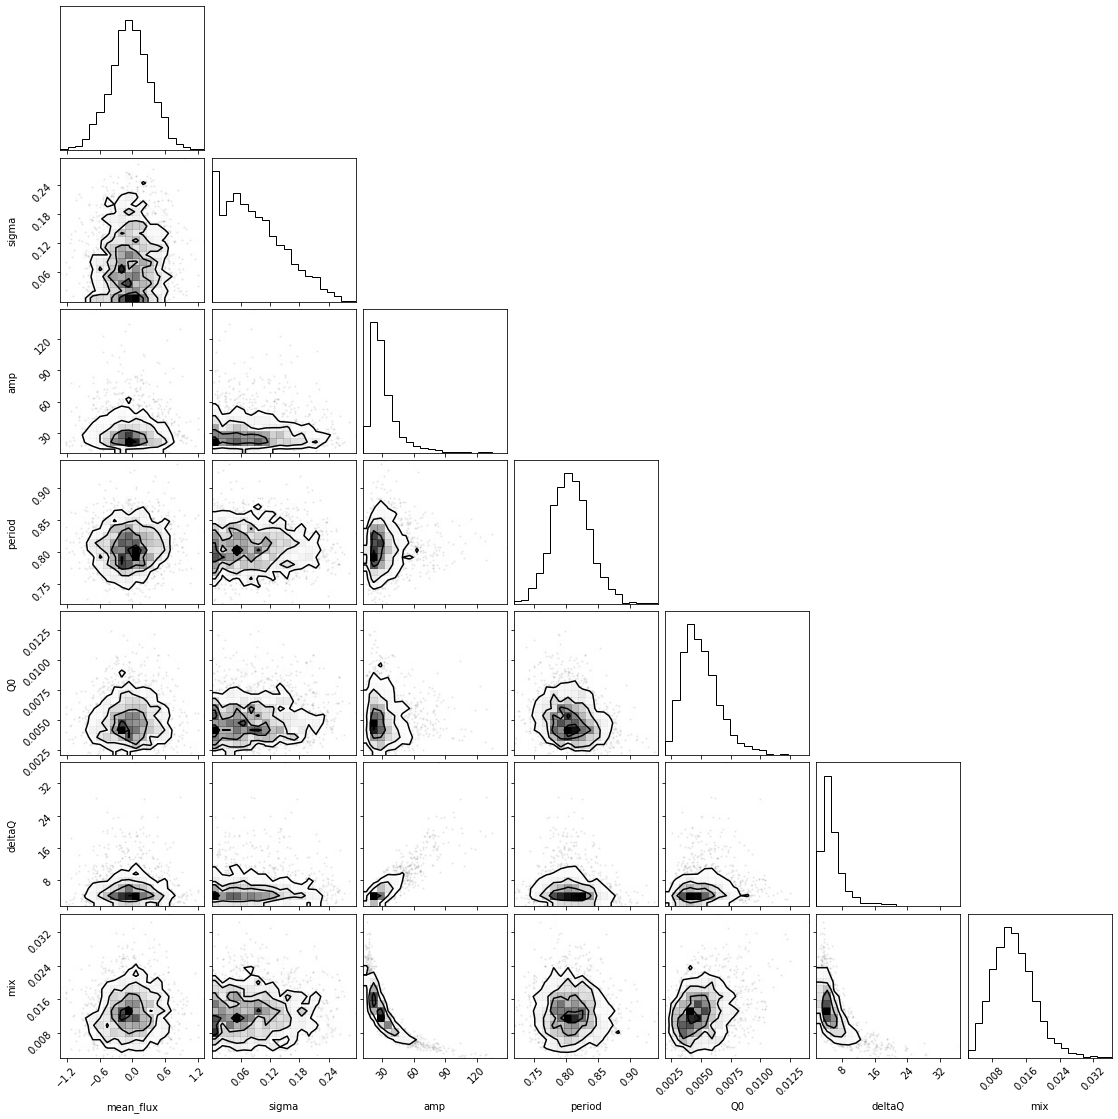

In [ ]:
import corner

corner.corner(pm.trace_to_dataframe(trace));